# Classification of Chicxulub core images

In [33]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.colors as colors

import numpy as np
import scipy as sp
import h5py
import pandas as pd

from scipy.misc import imresize

from skimage import data as skdata
from skimage import color
# from skimage.transform import resize

import xgboost as xgb

from keras import backend as K

import pydensecrf.densecrf as dcrf

In [34]:
import itertools

# This is a deprecated way to plot the confusion matrix from
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
# This is a function to create a discrete colormap, from Jake VanderPlas
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

For this notebook, we'll focus on a single core section image.  This is core 72-2 from the dataset (raw image data available [here](http://hs.pangaea.de/Images/Linescan/IODP/Exp364/364-M0077A_Line_Scan_Images/364-M0077A-072R-002_A67_scan.jpg)).  This data is licensed CC-BY 3.0, and made available by:

IODP Expedition 364 Scientists (2017): Line scan images of IODP Hole 364-M0077A. PANGAEA, https://doi.org/10.1594/PANGAEA.881718

Length per pixel: 0.00022651318232455017m
Original Shape: (2693, 396, 3)


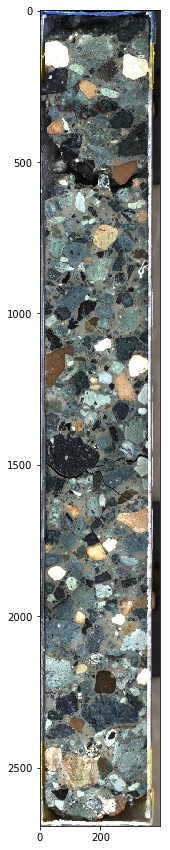

In [35]:
# load image
filename = "../data/364_77_A_072_R_002_scanA67.jpg"
img = skdata.imread(filename)

nh, nw, nc = img.shape

pixels_y = img.shape[0]
pixel_length = (699.02 - 698.41)/nh
print("Length per pixel: {}m".format(pixel_length))
print("Original Shape: {}".format(img.shape))

# convert image to LAB color space for additional features
img_lab = color.rgb2lab(img)

plt.figure(figsize=(5,15))
plt.imshow(img)
plt.show()

In [36]:
label_files = ['../data/72_2.h5']
training_list = []
classes = np.zeros((nh,nw))
for file_name in label_files:
    label_data = h5py.File(file_name)
    ar = label_data['exported_data'][...]
    
    # ilastik outputs all pixels, we just want the ones that were assigned a class
    indicies = np.nonzero(ar)
    labels = ar[indicies]
    cols = indicies[1]
    rows = indicies[0]
    # get the pixel number from row & column (C ordering, or row major)
    position = cols + rows * nw
    
    classes[rows,cols] = labels
    classes[classes == 0] = np.NaN
    
    # create pandas dataframe
    training_set = pd.DataFrame(data={'row':rows, 'col':cols, 
                                    'label':labels,
                                    'position':position})
    training_list.append(training_set)
    
training_data = pd.concat(training_list)

In [37]:
from keras.applications.vgg16 import VGG16

input_shape=(nh, nw, nc)
model = VGG16(include_top = False, 
              input_shape = input_shape)

In [38]:
# need to expand the first image dimension to pass it to VGG-16
# think about feeding in many images along this axis (if we had more images)
im_data = np.expand_dims(img, axis=0)
print("Prepared data shape: {}".format(im_data.shape))

Prepared data shape: (1, 2693, 396, 3)


Define a function to extract hypercolumns using the pretrained VGG-16 conv net,
and the input image.  This is based on Christian Perone's blog post at: http://blog.christianperone.com/2016/01/convolutional-hypercolumns-in-python/

In [39]:
def extract_hypercolumn(model, layer_indexes, instance):
    
    layers = [model.layers[li].output for li in layer_indexes]

    
    get_feature = K.function([model.layers[0].input], layers)
    
    feature_maps = get_feature(instance)
    
    
    hypercolumns = []
    for convmap in feature_maps:
        
        for fmap in convmap[0].transpose((2,0,1)):
            upscaled = sp.misc.imresize(fmap, size=(nh, nw),
                                        mode="F", interp='bilinear')
            hypercolumns.append(upscaled)
    return np.asarray(hypercolumns)

This diagram shows the convolutional layers of the VGG-16 network.  The 3rd and 6th layers are max pooling layers, and they will be extracted to form the hypercolumns.

![VGG 16 Schematic](hc_schematic.png)

In [40]:
# For VGG-16, layers 3 and 6 are the first two max-pooling layers
hc = extract_hypercolumn(model, [3, 6], [im_data])

# Add the 3 LAB color components to the hypercolumn vector as additional features
hc = np.concatenate((img_lab.transpose(2,0,1), hc), axis=0)

pixel_features = hc.transpose(1,2,0).reshape(nh*nw, -1)

print("feature shape: {}".format(pixel_features.shape))

/home/brendon/.edm/envs/apc-petro/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  app.launch_new_instance()


feature shape: (1066428, 195)


Now we can select out the features associated with each pixel in the training set.

In [41]:
training_vectors = pixel_features[training_data.position.values]
training_classes = training_data.label

nclasses = training_classes.unique().size
print('There are %d distinct classes in the training set.'%(nclasses))
# let's give them names
class_names = ['Impact-Light', 'Impact-Medium', 'Impact-Dark',
               'Impact-Green', 'Carb-White', 'Carb-Tan',
               'Carb-Brown','RedSiltstone','Chert', 'Basement-Mafic',
               'Basement-Felsic','Void', 'Liner', 'Matrix']

There are 14 distinct classes in the training set.


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(training_vectors, training_classes, 
                     test_size=0.05, random_state=42)

Use XGBoost library and a boosted tree model to make a model to classify pixels based on their hypercolumn features.

In [43]:
xg_train = xgb.DMatrix(X_train, label=y_train-1)
xg_test = xgb.DMatrix(X_test, label=y_test-1)
X_train

array([[ 1.00000000e+02, -2.45493786e-03,  4.65342115e-03, ...,
         0.00000000e+00,  0.00000000e+00,  3.53215942e+02],
       [ 9.97812209e+01, -9.87438361e-01, -3.41110700e-01, ...,
         4.62745514e+02,  3.42865295e+02,  1.76197717e+03],
       [ 4.79808277e+01,  5.35214306e+00,  1.49654149e+01, ...,
         6.81994507e+02,  1.13546654e+02,  2.36999039e+02],
       ...,
       [ 1.26312083e+01, -4.35047232e-03, -3.82583493e+00, ...,
         4.57927124e+02,  6.08944416e+00,  1.07694836e+03],
       [ 4.60336998e+01,  2.11659155e+00,  1.50856485e+01, ...,
         8.90309448e+02,  1.52552478e+03,  8.31303177e+01],
       [ 3.75674323e+01,  6.90916611e+00, -1.71644073e+01, ...,
         5.12524452e+01,  8.51270996e+02,  2.31399829e+03]])

In [44]:
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softprob'
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = nclasses

num_round = 3

In [45]:
bst = xgb.train(param, xg_train, num_round)

[23:35:59] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [46]:
class_probs = bst.predict(xg_test)
class_probs.shape

(12975, 14)

In [47]:
y_pred = np.argmax(class_probs, axis=1) + 1

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

print('\n'+classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.90      0.89      0.89       484
           2       0.82      0.81      0.81       774
           3       0.86      0.92      0.89      1755
           4       0.90      0.80      0.85       385
           5       0.91      0.91      0.91       504
           6       0.93      0.98      0.95      1777
           7       0.95      0.98      0.96       690
           8       0.75      0.79      0.77       119
           9       0.89      0.89      0.89       220
          10       0.85      0.79      0.82      1077
          11       0.80      0.53      0.63       219
          12       0.88      0.81      0.84      1284
          13       0.94      0.94      0.94      2885
          14       0.82      0.89      0.85       802

    accuracy                           0.89     12975
   macro avg       0.87      0.85      0.86     12975
weighted avg       0.89      0.89      0.89     12975



Let's take a look at the most important features in the dataset.

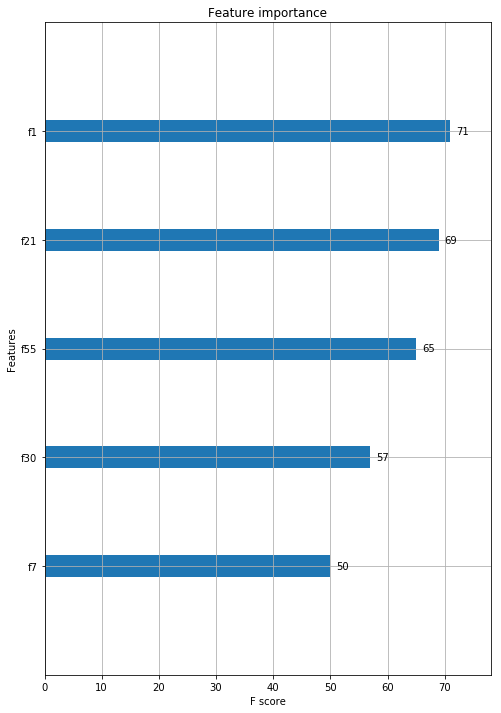

In [49]:
fig, ax = plt.subplots(1,1,figsize=(8,12))
xgb.plot_importance(bst, ax=ax, max_num_features=5)

The three most important features in the hypercolum vector are at indices 1, 21 and 55.  F1 the luminosity value from the LAB color space.  Let's take a look at a map of feature 21 and 55.

Text(0.5,1,'Feature 21')

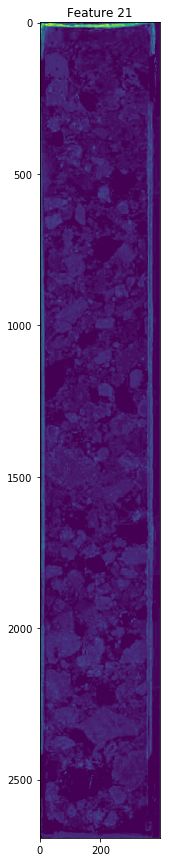

In [50]:
plt.figure(figsize=(5,15))
plt.imshow(hc[21])
plt.title('Feature 21')

Text(0.5,1,'Feature 55')

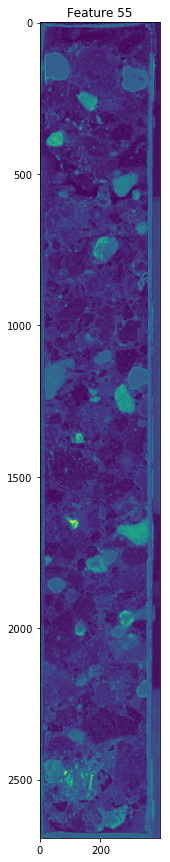

In [51]:
plt.figure(figsize=(5,15))
plt.imshow(hc[55])
plt.title('Feature 55')

Now apply the trained classifier to all the pixel hypercolumn data.

In [52]:
d_data = xgb.DMatrix(pixel_features)
data_probs = bst.predict(d_data)
y_all = np.argmax(data_probs, axis=1) + 1

In [53]:
labeled_img = y_all.reshape(nh, nw)

Confusion matrix, without normalization


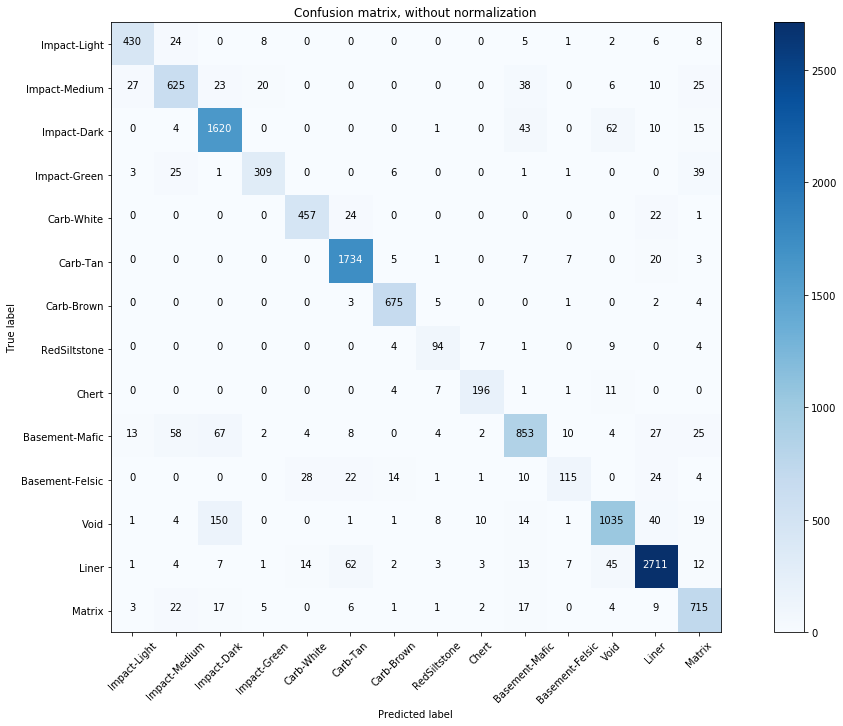

In [54]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')

Set up a color map for each of the clasts in the image.  These are just based on the colors used by the geoscientist who labeled the initial image, no real system at work here.

In [55]:
clast_color_map = {
 u'Impact-Light': '#B3B3B3',
 u'Impact-Medium': '#808080',
 u'Impact-Dark': '#4D4D4D',
 u'Impact-Green': '#1bd69e',
 u'Carb-White': '#2CFFFE',
 u'Carb-Tan': '#0B24FB',
 u'Carb-Brown': '#020C7E',
 u'RedSiltstone': '#807F17',
 u'Chert': '#0F7F12',
 u'Basement-Mafic': '#7E0308',
 u'Basement-Felsic': '#FC0D1B',
 u'Void': '#0E0E0E',
 u'Liner': '#FFFFFF',
 u'Matrix': '#FC6621',
}

clast_colors = []
for name in class_names:
    clast_colors.append(clast_color_map[name])
cmap_clasts = colors.ListedColormap(clast_colors, 'indexed')

Plot the raw classification.  This classification is quite noisy due to the fact that the pixels are classified indepdendant of one another.  We'll regulate this classification next.

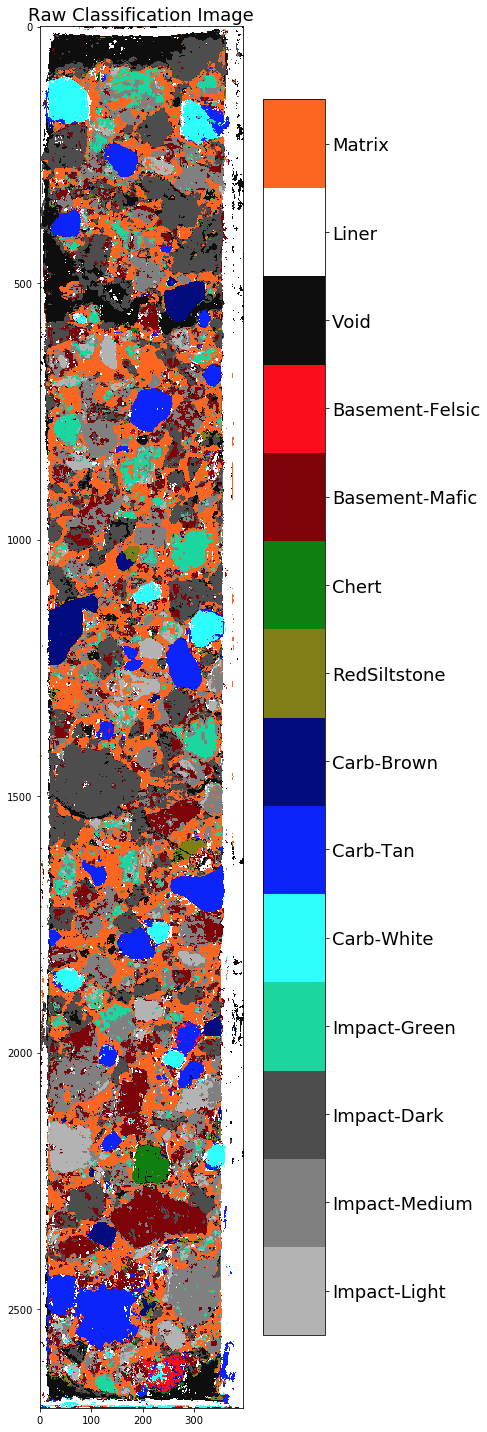

In [56]:
fig, ax = plt.subplots(figsize=(8,20))
cax = ax.imshow(labeled_img, 
                cmap=cmap_clasts,
                clim=(0.5,  nclasses + 0.5))
cbar = fig.colorbar(cax, ticks=range(nclasses+1))
cbar.ax.set_yticklabels(class_names, fontsize=18)
plt.title('Raw Classification Image', fontsize=18)
plt.tight_layout()
plt.show()

## Regularization
Use the `pydensecrf` library from https://github.com/lucasb-eyer/pydensecrf.  This follows the example closely from the readme on the repo.  The parameters were adjusted by visual inspection of the results.

First, the unary potential are the class probabilities from the xgboost classifier.

In [57]:
d = dcrf.DenseCRF2D(nw, nh, nclasses)  # width, height, nlabels

unary = data_probs
unary.shape

U = -np.log(unary.astype(np.float32))

print(U.shape)        # -> (5, 640, 480)

U = np.ascontiguousarray(np.transpose(U, (1,0)))
U = U.reshape((nclasses,-1), order='C')
d.setUnaryEnergy(U)

(1066428, 14)


In [58]:
d.addPairwiseGaussian(sxy=(3,3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

d.addPairwiseBilateral(sxy=10, srgb=20, rgbim=img, compat=40)

In [59]:
Q = d.inference(5)

In [60]:
crf_image = np.argmax(Q, axis=0).reshape((nh, nw))

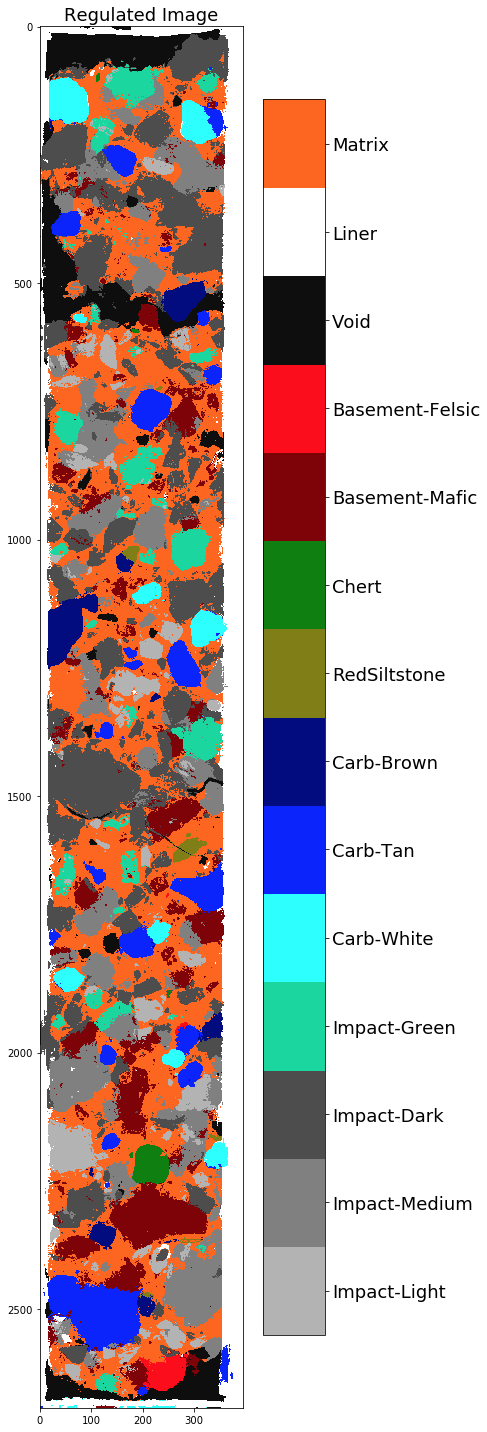

In [61]:
fig, ax = plt.subplots(figsize=(8,20))
cax = ax.imshow(crf_image+1, 
                cmap=cmap_clasts,
                clim=(0.5,  nclasses + 0.5))
cbar = fig.colorbar(cax, ticks=range(nclasses+1))
cbar.ax.set_yticklabels(class_names, fontsize=18)
plt.title('Regulated Image', fontsize=18)
plt.tight_layout()
plt.show()

Create a plot showing the training data alongside the regulated classification.

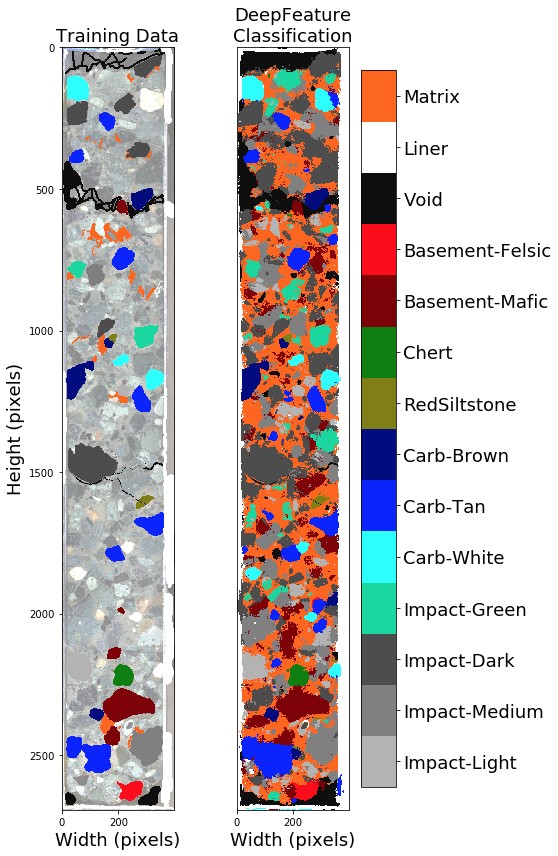

In [62]:
# get image of training data
training_img = ar[:,:,0]/1.
# make the unlabeled pixels transparent
training_img[training_img == 0] = np.nan

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,12))

ax1.imshow(img, alpha=0.5)
ax1.imshow(training_img, 
           cmap=cmap_clasts,
           clim=(0.5,  nclasses + 0.5))
ax1.set_title('Training Data', fontsize=18)
ax1.set_ylabel('Height (pixels)', fontsize=18)
ax1.set_xlabel('Width (pixels)', fontsize=18)

cax = ax2.imshow(crf_image+1, 
                cmap=cmap_clasts,
                clim=(0.5,  nclasses + 0.5))
cbar = fig.colorbar(cax, ticks=range(nclasses+1))
cbar.ax.set_yticklabels(class_names, fontsize=18)
ax2.set_title('DeepFeature\nClassification', fontsize=18)
ax2.set_yticks([])
ax2.set_xlabel('Width (pixels)', fontsize=18)

plt.tight_layout()
plt.show()